In [132]:
import sqlite3
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , accuracy_score
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
from sklearn.impute import SimpleImputer
import os

> * Se extrae un dataset sqlite de soccer europeo 

In [133]:
# Ruta de la base de datos descargada
db_path = "soccer_db/database.sqlite"

# Intentar conectar a la base de datos
try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Verificar las tablas en la base de datos
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    print("Tablas en la base de datos:", tables)
    
    # Cerrar la conexión
    conn.close()
except Exception as e:
    print("Error al conectar a la base de datos:", e)

Tablas en la base de datos: [('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [134]:
# Conectar a la base de datos
conn = sqlite3.connect(db_path)

# Leer la tabla 'Player_Attributes' en un DataFrame
df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [136]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [137]:
df.shape

(183978, 42)

> * Limpieza y pre procesamiento del df ( Simple Imputer)

In [138]:
# Ver cantidad de valores nulos por columna
missing_values = df.isnull().sum()

# Mostrar solo columnas con valores nulos
print(missing_values[missing_values > 0])

overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving               836
gk_handling             836
gk_kicking          

In [139]:
df.dtypes.value_counts()

float64    35
object      4
int64       3
Name: count, dtype: int64

In [140]:
# Separar columnas numéricas y categóricas
num_cols = df.select_dtypes(include=['float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Convertir todas las columnas categóricas a string para evitar problemas
df[cat_cols] = df[cat_cols].astype(str)

# Reimputar valores nulos para asegurarnos de que todo se procesa correctamente
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Verificar nuevamente valores nulos
print("Valores nulos restantes después de la imputación:")
print(df.isnull().sum().sum())  # Esto debería ser 0

Valores nulos restantes después de la imputación:
0


>* Despues de Explorar el df se extraen las Caracteristicas Necesarias para el modelo

In [141]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [142]:
# Definimos Features para el modelo
features = [
       'potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']

In [143]:
# Definimos Tarjet ( Variable Dependiente de las caracteristicas o features)
target = ['overall_rating']

>* Separamos caracteristicas y tarjet en sus respectivas variables 

In [144]:
x = df[features]
y = df[target]

In [145]:
x.head()

,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [146]:
y.head()

,overall_rating
0,67.0
1,67.0
2,62.0
3,61.0
4,61.0


<Figure size 1400x1000 with 0 Axes>

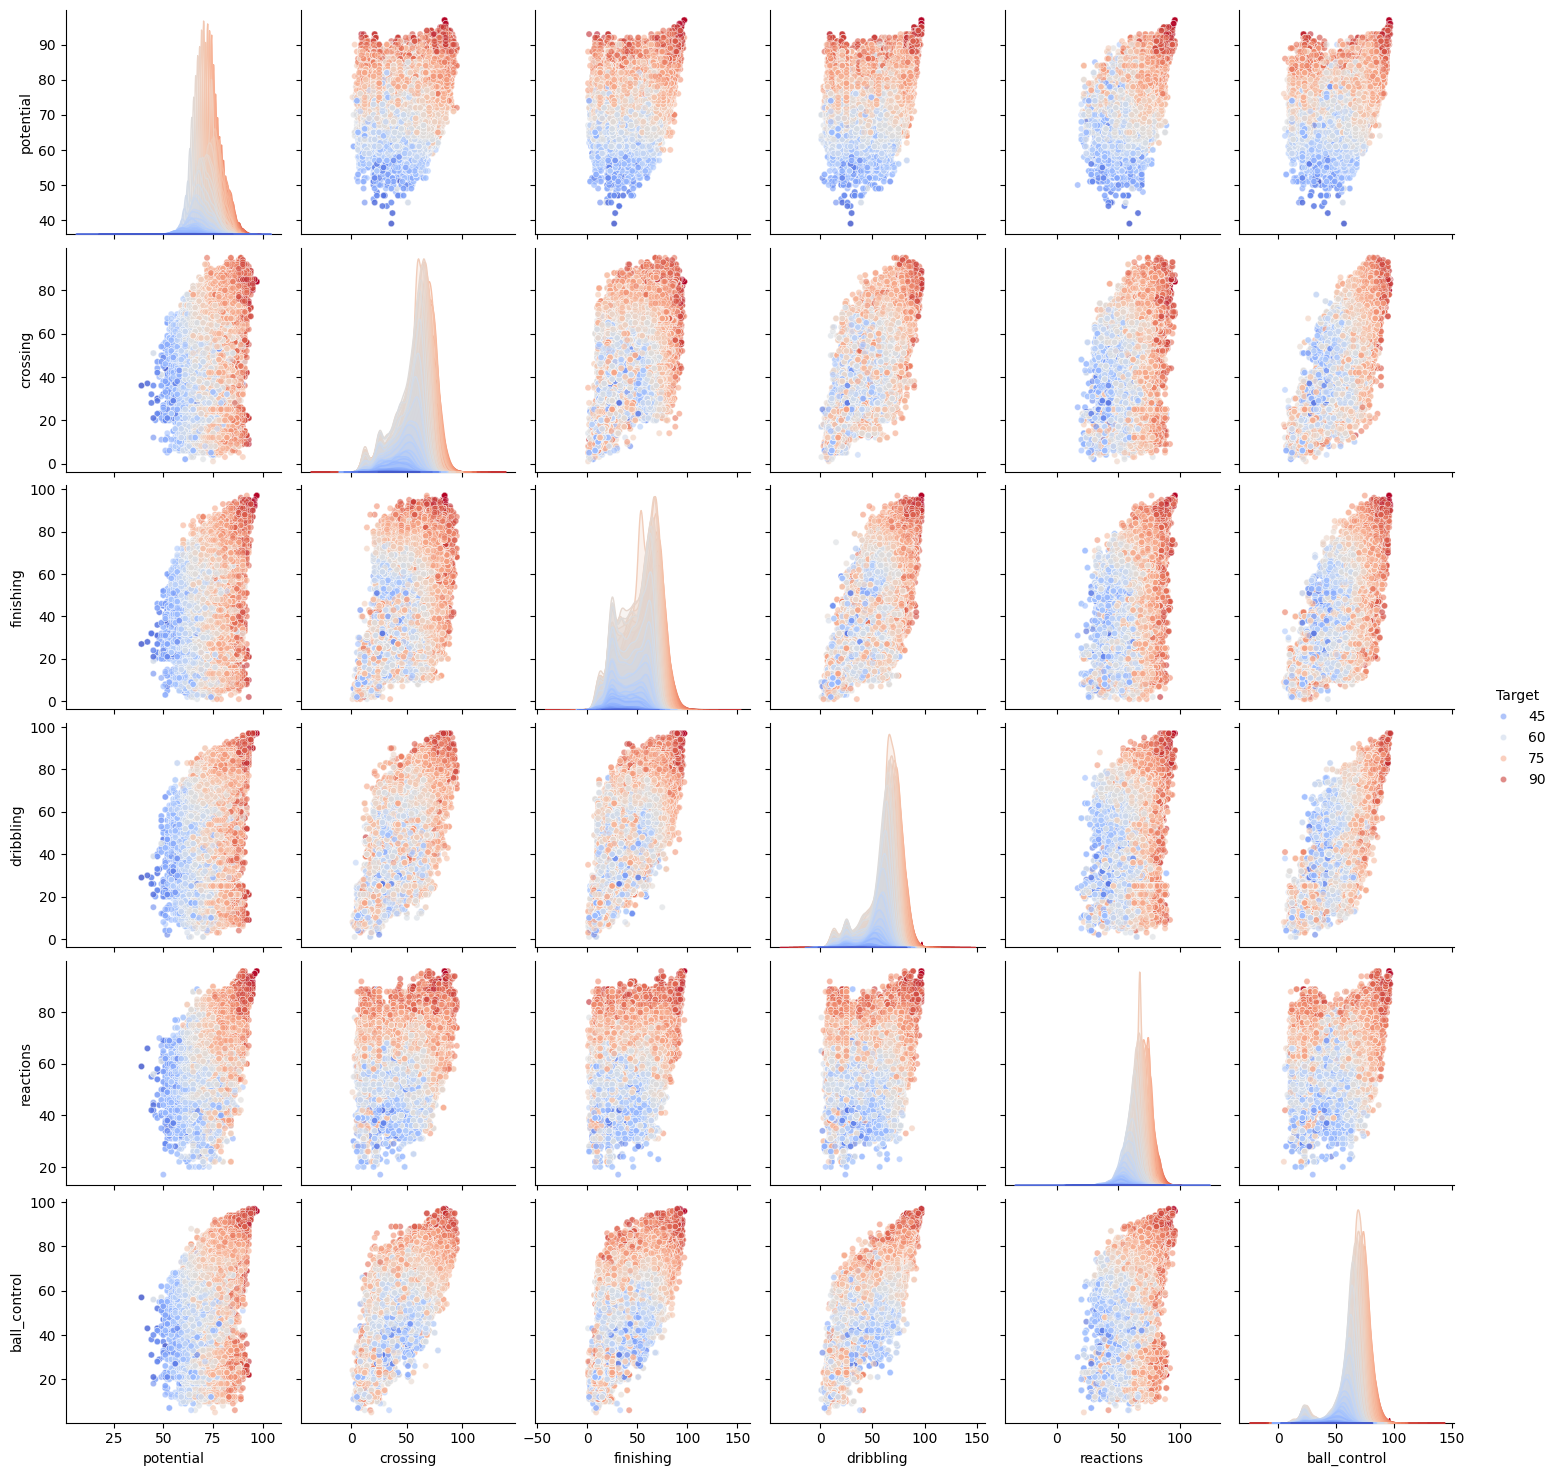

In [147]:
# Seleccionar algunas columnas relevantes para visualización
selected_features = [
    'potential', 'crossing', 'finishing', 'dribbling', 'reactions', 'ball_control'
]

# Crear un DataFrame con las características seleccionadas y la variable objetivo
df_plot = df[selected_features].copy()
df_plot['Target'] = y  # Añadir la variable objetivo

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 10))

# Crear un Pairplot con Seaborn para visualizar la relación de varias variables con el objetivo
sns.pairplot(df_plot, hue="Target", palette="coolwarm", diag_kind="kde", plot_kws={"alpha": 0.6, "s": 20})

# Mostrar el gráfico
plt.show()

>* Separamos los datos en Training y Test de  ( Seleccionamos datos y etiquetas y nos reservamos un 33% de los datos para testeo , porteriormente se implanta una semilla para que el resultado sea replicable es decir cada que se ejecute el codigo se dividan los datos igual)

In [148]:
X_train , X_test , y_train , y_test = train_test_split(x , y , test_size = 0.33 , random_state = 324)

In [149]:
scale = preprocessing.StandardScaler()
scale.fit(X_train)

StandardScaler()

In [150]:
X_train = scale.transform(X_train)

In [151]:
X_train

array([[-1.28552664,  0.63054575, -0.26190203, ..., -0.55792451,
        -0.69217662, -0.31488192],
       [ 0.08064905, -0.35755259,  0.52812642, ..., -0.3241572 ,
        -0.19207353, -0.60732102],
       [-1.28552664,  0.33992859,  0.00144079, ..., -0.51117105,
        -0.3170993 , -0.5488332 ],
       ...,
       [-1.13372934, -0.47379945, -0.3145706 , ..., -0.27740374,
        -0.37961219, -0.60732102],
       [-1.43732394, -0.008812  ,  0.2647836 , ..., -0.55792451,
        -0.12956064, -0.43185756],
       [-0.22294555,  0.57242232,  0.05410935, ..., -0.60467797,
        -0.06704775, -0.49034538]], shape=(123265, 34))

In [152]:
# Hacemos el escalado para evitar sesgos y verificamos variaciones en los valores en esta caso minimo y maximo
print("Minimo : " , X_train.min())
print("Maximo : " , X_train.max())

Minimo :  -5.2322564120084785
Maximo :  4.9964960608137945


In [153]:
# Creamos una instancia del modelo de regresion lineal de scikit learn
regressor = LinearRegression()
# Ajustamos el modelo a los datos de entrenamiento
regressor.fit(X_train, y_train)

LinearRegression()

In [154]:
# Llevamos a cabo una prediccion utilizando el 33% que reservamos del df para teste0
X_test = scale.transform(X_test)
y_prediction = regressor.predict(X_test)
y_result = y_prediction - y_test
y_prediction.shape

(60713, 1)

In [155]:
rmse = sqrt(mean_squared_error(y_true = y_test , y_pred = y_prediction))
regressor.score(X_test , y_test)

0.8395790507202474

In [156]:
rmse

2.7935969204300313

In [157]:
regressor.coef_ # Valor por el que hay que multiplicar para que en la funcion te de el puntaje del jugador

array([[ 2.49427274,  0.40786934,  0.21873664,  1.16538664,  0.70490725,
         0.05936245, -0.22589319,  0.18464487,  0.23747532,  0.08831146,
         2.06159177,  0.06290384,  0.13885732, -0.11376889,  1.90800356,
         0.09358163,  0.25618146,  0.1665028 , -0.05939408,  0.7336077 ,
        -0.21529545,  0.31488728,  0.25154834, -0.17482149, -0.02923241,
         0.22105807,  0.68350566,  0.09306547, -0.63135603,  2.82945915,
         0.48730467, -0.70668257,  0.86759805,  0.40434013]])